<a href="https://colab.research.google.com/github/BradleyMerrillT/694/blob/main/FDAapprovals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Some of the most basic include Shift + Enter to run a cell, Ctrl + M Y to convert a cell to code cell, Ctrl + M M to convert a cell to text cell

## FDA 510(k) Clearance Analysis

In [1]:
!pip install lime

     |████████████████████████████████| 276kB 8.8MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-cp37-none-any.whl size=283846 sha256=47b65e4b78941174fb730319773d7a877dd38f03fb1dd037f57dcd026ce656f3
  Stored in directory: /root/.cache/pip/wheels/4c/4f/a5/0bc765457bd41378bf3ce8d17d7495369d6e7ca3b712c60c89
Successfully built lime


In [1]:
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt
import re
import numpy as np
from lime.lime_text import LimeTextExplainer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix
from sklearn.dummy import DummyClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB

# Creating dataset
z = np.random.randint(100, size =(50))
x = np.random.randint(100, size =(50))
y = np.random.randint(100, size =(50))
 
# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
 
# Creating plot
ax.scatter3D(x, y, z, color = "green")
plt.title("3D Data")
 
plt.xlabel('X axis')
plt.ylabel('Y axis')
ax.set_zlabel('Z axis')

# show plot
plt.show()

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Processing the OpenFDA data

f = open('/content/drive/My Drive/device-510k-0001-of-0001.json',) 
data = json.load(f) 

df = pd.DataFrame(data['results'])

df = pd.concat([df.drop(['openfda'], axis=1), df['openfda'].apply(pd.Series)], axis=1)
df = df.drop(['fei_number','medical_specialty_description', 'zip_code', 'address_2', 'advisory_committee'], axis=1)



df_sum = df.loc[df['statement_or_summary'] == 'Summary']


df_sum['year'] = df_sum['k_number'].str.findall(r"\d{2}").str[0]   #re.findall("\d{2}", df_sum['k_number'])[0]
df_sum['link'] = 'http://www.accessdata.fda.gov/cdrh_docs/pdf' + df_sum['year'].apply(lambda x: x.strip("0")) + '/' + df_sum['k_number'] + '.pdf' #.apply(lambda x: x.strip("0")) applied to year
df_sum['year'] = df_sum['year'].apply(pd.to_numeric) 
df_first = df_sum[df_sum['year'] > 0] 
#df_recent = df_first[df_first['year'] < 15]  
df_old = df_first[df_first['year'] < 6]  

#Reading the PDFs

pip install pdfminer.six

from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.layout import LAParams
from pdfminer.converter import TextConverter
from pdfminer.pdfpage import PDFPage
import io
import urllib.request
import requests


def pdf_to_text(pdf_file):
  try:
    text_memory_file = io.StringIO()
    rsrcmgr = PDFResourceManager()
    device = TextConverter(rsrcmgr, text_memory_file, laparams=LAParams())
    interpreter = PDFPageInterpreter(rsrcmgr, device)
    # get first 3 pages of the pdf file
    for page in PDFPage.get_pages(pdf_file):
        interpreter.process_page(page)
    text = text_memory_file.getvalue()
    text_memory_file.close()
    return text
  except:
    pass

# # online pdf to text by urllib
#online_pdf_file=urllib.request.urlopen('http://www.dabeaz.com/python/UnderstandingGIL.pdf')
#pdf_memory_file=io.BytesIO()
#pdf_memory_file.write(online_pdf_file.read())
# print(pdf_to_text(pdf_memory_file))

#df['summary'] = df['link'].apply(lambda x: x + 1)--can we revise lamda to implement the function below?

def web_pdf(link):
  try:
    response = requests.get(link)
    pdf_memory_file = io.BytesIO()
    pdf_memory_file.write(response.content)
    return pdf_to_text(pdf_memory_file)
  except:
    pass

df_old['summary'] = df_old['link'].apply(web_pdf)

#Storage

df_old.to_pickle('/content/drive/My Drive/df_1_5.pkl')  # where to save it, usually as a .pkl

#Final Pipeline

##Concatenate the years and remove duplicates

df_store_1 = pd.read_pickle('/content/drive/My Drive/df_10.pkl')
df_store_2 = pd.read_pickle('/content/drive/My Drive/df_11_12.pkl')
df_store_3 = pd.read_pickle('/content/drive/My Drive/df_13.pkl')
df_store_4 = pd.read_pickle('/content/drive/My Drive/df_14.pkl')
df_store_5 = pd.read_pickle('/content/drive/My Drive/df_15-20.pkl')
df_store_6 = pd.read_pickle('/content/drive/My Drive/df_1_5.pkl')
df_store_7 = pd.read_pickle('/content/drive/My Drive/df_6_9.pkl')

df_new = pd.concat([df_store_5, df_store_4, df_store_3, df_store_2, df_store_1, df_store_7, df_store_6])
df_new.to_pickle('/content/drive/My Drive/df_1_20.pkl')

df_new = pd.read_pickle('/content/drive/My Drive/df_1_20.pkl')

###When I add new data, be sue to remove duplicate rows

##Remove special and abbreviated 510(k)s

df_t = df_new[df_new['clearance_type']== 'Traditional']

##Add Clintrails.gov flag

df_ct_1 = pd.read_csv('/content/drive/My Drive/PMNExcelReport.csv')
df_ct_2 = pd.read_csv('/content/drive/My Drive/PMNExcelReport2.csv')
df_ct = pd.concat([df_ct_1, df_ct_2]).drop_duplicates(subset ="510(K) NUMBER", keep = False, inplace = False) 

df_with_ct = pd.merge(df_t, df_ct, how='left', left_on='k_number', right_on='510(K) NUMBER')

df_with_ct = df_with_ct.drop(['PRODUCT', 'COMPANY', 'APPROVAL DATE'], axis=1)

df_with_ct['510(K) NUMBER'] = df_with_ct['510(K) NUMBER'].replace('K\d\d\d\d\d\d', 1, regex=True)

df_with_ct = df_with_ct.rename(columns= {'510(K) NUMBER': 'CT_flag'})

df_with_ct['CT_flag'] = df_with_ct['CT_flag'].fillna(0).astype(int)
 

##Add clintrials indicator flag

df_with_ct["Clin_subjects"]= df_with_ct["summary"].str.find('subjects') + df_with_ct["summary"].str.find('Subjects')

df_with_ct["Clin_informed_consent"]= df_with_ct["summary"].str.find('informed consent') + df_with_ct["summary"].str.find('Informed consent')

df_with_ct["Clin_prospective"]= df_with_ct["summary"].str.find('prospective') + df_with_ct["summary"].str.find('Prospective')

df_with_ct["Clin_retrospective"]= df_with_ct["summary"].str.find('retrospective') + df_with_ct["summary"].str.find('Retrospective')

df_with_ct["Clin_randomized"]= df_with_ct["summary"].str.find('randomized') + df_with_ct["summary"].str.find('Randomized')

df_with_ct["Clin_cohort"]= df_with_ct["summary"].str.find('cohort') + df_with_ct["summary"].str.find('Cohort')

df_with_ct["Clin_single-blind"]= df_with_ct["summary"].str.find('single-blind') + df_with_ct["summary"].str.find('Single-blind')

df_with_ct["Clin_double-blind"]= df_with_ct["summary"].str.find('double-blind') + df_with_ct["summary"].str.find('Double-blind')

df_with_ct["Clin_observational_study"]= df_with_ct["summary"].str.find('observational study') + df_with_ct["summary"].str.find('Observational study')

df_with_ct['cli_tot'] = df_with_ct["Clin_subjects"] + df_with_ct["Clin_informed_consent"] + df_with_ct["Clin_prospective"] + df_with_ct["Clin_retrospective"] + df_with_ct["Clin_randomized"] + df_with_ct["Clin_cohort"] + df_with_ct["Clin_single-blind"] + df_with_ct["Clin_double-blind"] + df_with_ct["Clin_observational_study"]

df_with_ct['CT_sum_Flag'] = np.where(df_with_ct['cli_tot'] > -9, 1, 0)

##Extract variables from summary

###Clean Summary

#remove everything bwteeen the words Dear and sincerely
df_with_ct['summary'] = df_with_ct['summary'].replace("(?<=Dear)(.*)(?=Sincerely)", "", regex=True)
df_with_ct['summary'] = df_with_ct['summary'].replace("(?<=CONTINUE)(.*)(?=OMB)", "", regex=True)
df_with_ct['summary'] = df_with_ct['summary'].replace(r'\\n',' ', regex=True) 
df_with_ct['summary'] = df_with_ct['summary'].replace('\s+', ' ', regex=True)
df_with_ct['summary'] = df_with_ct['summary'].replace(',', ' ', regex=True)


banned = ['cid:' 'FORM FDA 3881', 'Center for Devices and Radiological Health', 'Office of Device Evaluation','Form Approved:', 'OMB No. 0910-0120', 'See PRA Statement below.', 'DEPARTMENT OF HEALTH & HUMAN SERVICES', 'Public Health Service', 'Food and Drug Administration', '10903 New Hampshire Avenue', 'Document Control Center - WO66-G609', 'Expiration Date:', 'Silver Spring', 'MD 20993-0002']

for i in banned:
  df_with_ct['summary'] = df_with_ct['summary'].str.replace(i, '')

###Indication for use

#pattern = "(?<=Indications)(.*)(?=CONTINUE)"
pattern = '\(Describe\)([\S\s]*)Type of Use'
#pattern = "(?<=Indications for Use(Describe))(.*)(?=Type of Use)"
pattern2 = 'Indications[\S\n ]{1,400}'

# Iterate over rate column of dataframe and perform regex to extract value
search = []    
for values in df_with_ct['summary']:
    try:
      search.append(re.search(pattern, values).group())
    except:
      try:
        search.append(re.search(pattern2, values).group())
      except:
        search.append('failed')
     

df_with_ct['indication_for_use'] = search


#df_with_ct['indication_for_use'] = df_with_ct['indication_for_use'].replace("(?<=Use)(.*)(?=\(Describe\))", "", regex=True)
df_with_ct['indication_for_use'] = df_with_ct['indication_for_use'].apply(lambda x : re.sub('Describe', '', x))
df_with_ct['indication_for_use'] = df_with_ct['indication_for_use'].apply(lambda x : re.sub('Type of Use', '', x))
#df['a'] = df['a'].apply(lambda x: x + 1)
#re.sub('(Describe)', '', string)

df_with_ct.iloc[398,39]

###Pro codes

#open product code file
pro_codes = pd.read_csv('/content/drive/My Drive/foiclass.txt', sep = '|', encoding = "ISO-8859-1")

pro_code_list = list(pro_codes.PRODUCTCODE)

# State regex pattern that extracts the value
pattern = 'Product Code[\S\n ]{1,40}'

search = []
final = []    
for values in df_with_ct['summary']:
    try:
      search.append(re.search(pattern, values).group())
      
    except:
      search.append('failed')

df_with_ct['pro_codes'] = search

lst = []    
for values in df_with_ct['pro_codes']:
    try:
      d = [item for item in values.split() if item in pro_code_list]  
      lst.append(d)
      
    except:
      lst.append('failed')

df_with_ct['pro_codes'] = lst

def duplicates(x):
  return list(set(x))

df_with_ct['pro_codes'] = df_with_ct.pro_codes.apply(duplicates)

###Predicate k Numbers

# regex pattern that extracts the value
pattern = 'K\d\d\d\d\d\d'

# Iterate over rate column of dataframe and perform regex to extract value
search = []    
for values in df_with_ct['summary']:
    try: 
      search.append(re.findall(pattern, values))
    except:
      search.append('failed')

df_with_ct['Pred_K_Numbers'] = search

df_with_ct['Pred_K_Numbers'] = df_with_ct.Pred_K_Numbers.apply(duplicates)

#Then remove the knumbers for that application with reference to the other column
for i, j in zip(df_with_ct.Pred_K_Numbers, df_with_ct.k_number):
    try:
      i.remove(j)
    except:
      i

#Remove any in excess of 5
lst = []    
for values in df_with_ct['Pred_K_Numbers']:
    try:
      if len(values) >= 5:
        d = values[:5]
      else:
        d = values 
      lst.append(d)
      
    except:
      lst.append('failed')

df_with_ct['Pred_K_Numbers'] = lst

df_with_ct.to_pickle('/content/drive/My Drive/df_final.pkl')

##Get rid of unneeded variables

In [2]:
df_temp = pd.read_pickle('/content/drive/My Drive/df_final.pkl')

In [3]:
df_fin = df_temp[['indication_for_use', 'pro_codes', 'Pred_K_Numbers', 'CT_flag', 'CT_sum_Flag']]
df_fin['CT_Real_Flag'] = df_fin['CT_flag'] + df_fin['CT_sum_Flag']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


len(df_fin[df_fin['CT_Real_Flag']==2])

###Only 300 0f the 500 clin trials.gov overlapped with the rough approximation search

In [4]:
#df_fin['CT_Real_Flag'] = np.where((df_fin.CT_Real_Flag == 2), 1, df_fin.CT_sum_Flag)

df_fin.loc[(df_fin.CT_Real_Flag == 2), 'CT_Real_Flag'] = 1

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [5]:
#df_fin2 = pd.concat([pd.DataFrame(df_fin['Pred_K_Numbers'].values.tolist()), pd.DataFrame(df_fin['pro_codes'].values.tolist()), df_fin['indication_for_use'], df_fin['CT_flag'], df_fin['CT_Real_Flag']], axis=1)

In [7]:
df_iu = df_fin[['indication_for_use', 'CT_Real_Flag']]

df_iu.iloc[0,0]

#Unsupervised learning

###https://scikit-learn.org/stable/auto_examples/text/plot_document_clustering.html

###https://towardsdatascience.com/k-means-clustering-8e1e64c1561c

In [8]:
from sklearn.cluster import KMeans 
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.metrics import pairwise_distances

import nltk
import string

##Vectorize the indications for use

In [9]:
train_df, dev_df, test_df = np.split(df_iu.sample(frac=1, random_state=1), [int(.8*len(df_iu)), int(.9*len(df_iu))])

In [10]:
vectorizer = TfidfVectorizer(min_df = 10, stop_words = 'english') # , ngram_range=(1,2)
X_train = vectorizer.fit_transform(train_df['indication_for_use'])

In [11]:
y_train = list(train_df.CT_Real_Flag)

##K means clustering

In [12]:
tf_idf_norm = normalize(X_train)
tf_idf_array = tf_idf_norm.toarray()

pd.DataFrame(tf_idf_array, columns=vectorizer.get_feature_names()).head()

In [13]:
class Kmeans:
    """ K Means Clustering
    
    Parameters
    -----------
        k: int , number of clusters
        
        seed: int, will be randomly set if None
        
        max_iter: int, number of iterations to run algorithm, default: 200
        
    Attributes
    -----------
       centroids: array, k, number_features
       
       cluster_labels: label for each data point
       
    """
    
    def __init__(self, k, seed = None, max_iter = 200):
        self.k = k
        self.seed = seed
        if self.seed is not None:
            np.random.seed(self.seed)
        self.max_iter = max_iter
        
            
    
    def initialise_centroids(self, data):
        """Randomly Initialise Centroids
        
        Parameters
        ----------
        data: array or matrix, number_rows, number_features
        
        Returns
        --------
        centroids: array of k centroids chosen as random data points 
        """
        
        initial_centroids = np.random.permutation(data.shape[0])[:self.k]
        self.centroids = data[initial_centroids]

        return self.centroids

In [19]:
def assign_clusters(self, data):
    """Compute distance of data from clusters and assign data point
        to closest cluster.
    
    Parameters
    ----------
    data: array or matrix, number_rows, number_features
    
    Returns
    --------
    cluster_labels: index which minmises the distance of data to each
    cluster
        
    """
    
    if data.ndim == 1:
        data = data.reshape(-1, 1)
    
    dist_to_centroid =  pairwise_distances(data, self.centroids, metric = 'euclidean')
    self.cluster_labels = np.argmin(dist_to_centroid, axis = 1)
    
    return  self.cluster_labels
    
    
def update_centroids(self, data):
    """Computes average of all data points in cluster and
        assigns new centroids as average of data points
    
    Parameters
    -----------
    data: array or matrix, number_rows, number_features
    
    Returns
    -----------
    centroids: array, k, number_features
    """
    
    self.centroids = np.array([data[self.cluster_labels == i].mean(axis = 0) for i in range(self.k)])
    
    return self.centroids

In [20]:
def predict(self, data):
    """Predict which cluster data point belongs to
    
    Parameters
    ----------
    data: array or matrix, number_rows, number_features
    
    Returns
    --------
    cluster_labels: index which minmises the distance of data to each
    cluster
    """
    
    return self.assign_clusters(data)

def fit_kmeans(self, data):
    """
    This function contains the main loop to fit the algorithm
    Implements initialise centroids and update_centroids
    according to max_iter
    -----------------------
    
    Returns
    -------
    instance of kmeans class
        
    """
    self.centroids = self.initialise_centroids(data)
    
    # Main kmeans loop
    for iter in range(self.max_iter):

        self.cluster_labels = self.assign_clusters(data)
        self.centroids = self.update_centroids(data)          
        if iter % 100 == 0:
            print("Running Model Iteration %d " %iter)
    print("Model finished running")
    return self

In [22]:
sklearn_pca = PCA(n_components = 2)
Y_sklearn = sklearn_pca.fit_transform(tf_idf_array)
#test_e = Kmeans(3, 1, 600)
#fitted = test_e.fit_kmeans(Y_sklearn)
#predicted_values = test_e.predict(Y_sklearn)


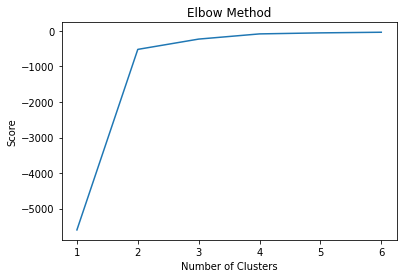

In [23]:
number_clusters = range(1, 7)

kmeans = [KMeans(n_clusters=i, max_iter = 600) for i in number_clusters]
kmeans

score = [kmeans[i].fit(Y_sklearn).score(Y_sklearn) for i in range(len(kmeans))]
score

plt.plot(number_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Method')
plt.show()

In [27]:
from sklearn.cluster import KMeans
sklearn_pca = PCA(n_components = 2)
Y_sklearn = sklearn_pca.fit_transform(tf_idf_array)
kmeans = KMeans(n_clusters=2, max_iter=600, algorithm = 'auto')
fitted = kmeans.fit(Y_sklearn)
prediction = kmeans.predict(Y_sklearn)

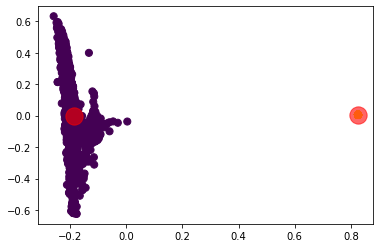

In [29]:
plt.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1], c=prediction, s=50, cmap='viridis')

centers = fitted.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1],c='red', s=300, alpha=0.6);

In [32]:
def get_top_features_cluster(tf_idf_array, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) # indices for each cluster
        x_means = np.mean(tf_idf_array[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = vectorizer.get_feature_names()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs
dfs = get_top_features_cluster(tf_idf_array, prediction, 15)

In [47]:
np_array = np.array(dfs)
reshaped_array = np.reshape(np_array, (30, 2))
df_common = pd.DataFrame(reshaped_array, columns = ['Feature', 'Score'])

In [49]:
dfc1 = df_common.iloc[:15,:]
dfc2 = df_common.iloc[16:,:]


,Feature,Score
0,use,0.0692274
1,indications,0.0442613
2,intended,0.0337171
3,device,0.0336306
4,used,0.0233288
5,21,0.0220109
6,cid,0.0210809
7,indicated,0.0209269
8,cfr,0.0203548
9,number,0.0202713


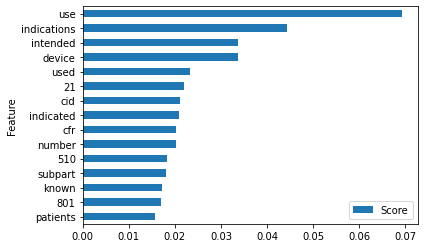

In [52]:
ax = dfc1.plot.barh(x='Feature', y='Score', rot=0)
ax.invert_yaxis()

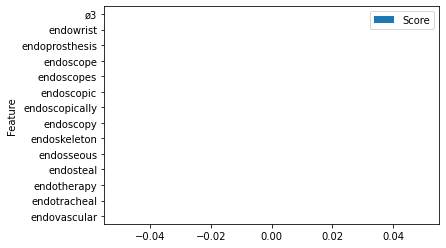

In [53]:
ax = dfc2.plot.barh(x='Feature', y='Score', rot=0)
ax.invert_yaxis()

##Logistic regression

In [42]:
clf = LogisticRegression(random_state = 1, solver= 'lbfgs')
clf.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=1, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [43]:
X_dev = vectorizer.transform(dev_df['indication_for_use'])
y_dev = list(dev_df.CT_Real_Flag)

#dummyclassifier

In [44]:
dummy_clf_mf = DummyClassifier(strategy="most_frequent", random_state = 1)
dummy_clf_u = DummyClassifier(strategy="uniform", random_state = 1)


dummy_clf_mf.fit(X_train, y_train)
dummy_clf_u.fit(X_train, y_train)

DummyClassifier(constant=None, random_state=1, strategy='uniform')

#Naive Bayes

In [45]:
NB = MultinomialNB()
NB.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

##Prediction

In [46]:
dev_preds = clf.predict(X_dev)

In [47]:
mf_dev_preds = dummy_clf_mf.predict(X_dev)
u_dev_preds = dummy_clf_u.predict(X_dev)

In [48]:
dev_preds_NB = NB.predict(X_dev)

##Evaluation: Logistic Reg, Dummy and Naive Bayes

In [49]:
#https://machinelearningmastery.com/tour-of-evaluation-metrics-for-imbalanced-classification/
accuracy_score(y_dev, dev_preds) #, average='binary' for f1

0.9305522064142754

In [50]:
confusion_matrix(y_dev, dev_preds)

array([[3813,   11],
       [ 277,   46]])

In [51]:
accuracy_score(y_dev, mf_dev_preds)

0.9221123703882325

In [52]:
confusion_matrix(y_dev, mf_dev_preds)

array([[3824,    0],
       [ 323,    0]])

In [53]:
accuracy_score(y_dev, u_dev_preds)

0.5092838196286472

In [54]:
confusion_matrix(y_dev, u_dev_preds)

array([[1941, 1883],
       [ 152,  171]])

In [55]:
accuracy_score(y_dev, dev_preds_NB)

0.9274174101760309

In [56]:
confusion_matrix(y_dev, dev_preds_NB)

array([[3768,   56],
       [ 245,   78]])

#XG Booster

In [57]:
XGmodel = XGBClassifier()
XG_dev_preds = XGmodel.fit(X_train, y_train).predict(X_dev)

accuracy_score(y_dev, XG_dev_preds)

0.9291053773812394

In [58]:
confusion_matrix(y_dev, XG_dev_preds)

array([[3813,   11],
       [ 283,   40]])

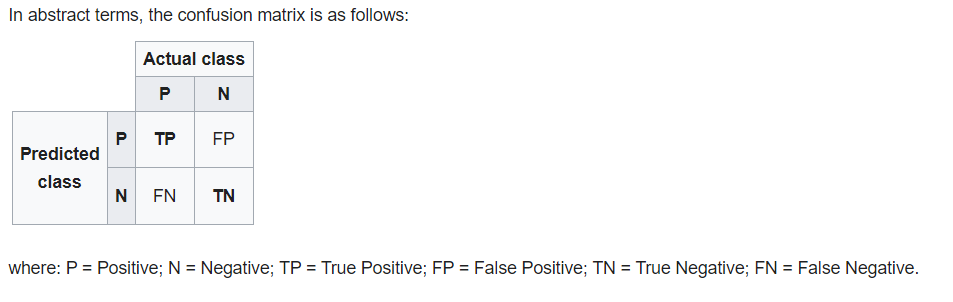

##Explanation

In [59]:
LTE = LimeTextExplainer(class_names=['Clinical trial required', 'No clinical trial'])
pipe = make_pipeline(vectorizer, clf)


In [60]:
test_row_df = test_df.sample(1, random_state=800)
_, inst_text, label = next(test_row_df.itertuples())

In [61]:
explanation = LTE.explain_instance(inst_text, pipe.predict_proba, num_features=10)

In [62]:
print(inst_text)

Indications for use Optomed Smartscope M5 with EY4 and ESZ Optomed Smartscope MS digital camera with EY4 optics module is intended to capture digital images and video of the fundus of the human eye. Optomed Smartscope MS with optics module ES2 is intended to capture images and video of the surface of the human eye and areas. Prescription use intended to use without mydriatic but can be used also with mydriat


In [63]:
print(label)

0


In [64]:
pipe.predict_proba([inst_text]) #[0, 1]

array([[0.91688406, 0.08311594]])

In [65]:
for feat, val in explanation.as_list():
    print('LogisticRegression has an estimated weight of %f on feature "%s"' % (val, feat))

LogisticRegression has an estimated weight of 0.036031 on feature "eye"
LogisticRegression has an estimated weight of 0.024728 on feature "human"
LogisticRegression has an estimated weight of -0.021911 on feature "digital"
LogisticRegression has an estimated weight of -0.012188 on feature "Indications"
LogisticRegression has an estimated weight of 0.010425 on feature "fundus"
LogisticRegression has an estimated weight of -0.010080 on feature "use"
LogisticRegression has an estimated weight of -0.009830 on feature "optics"
LogisticRegression has an estimated weight of -0.008486 on feature "capture"
LogisticRegression has an estimated weight of -0.008233 on feature "images"
LogisticRegression has an estimated weight of -0.007222 on feature "video"


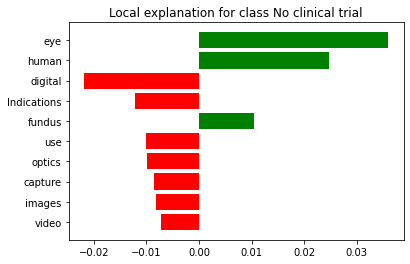

In [66]:
fig = explanation.as_pyplot_figure()

In [67]:
#clf.predict_proba(vectorizer.transform(test_row_df['indication_for_use']))

###let's add some more information

In [68]:
#https://kavita-ganesan.com/news-classifier-with-logistic-regression-in-python/#.X-OhR9hKhPY

df_fin.head()

,indication_for_use,pro_codes,Pred_K_Numbers,CT_flag,CT_sum_Flag,CT_Real_Flag
0,Indications for Use The measurement of hemoglo...,"[JJE, LCP]",[K071466],0,1,1
1,Indications for use Technological characterist...,[DQK],"[K151245, K161240]",0,0,0
2,Indications for Use January 31 2017 510(k...,[GEX],[K113588],0,0,0
3,() GingiKnit+ GingiBraid+ and Shortcut with ...,[MVL],[K131799],0,0,0
4,() The IRRIS is intended for use as an aid in ...,[BTR],"[K110962, K954771, K962361]",0,0,0


In [69]:
df_fin['prostring'] = [', '.join(map(str, l)) for l in df_fin['pro_codes']]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [70]:
df_fin['tot'] = df_fin['indication_for_use'] + ' ' + df_fin['prostring']


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [71]:
train_df_fin, dev_df_fin, test_df_fin = np.split(df_fin.sample(frac=1, random_state=1), [int(.8*len(df_fin)), int(.9*len(df_fin))])

In [72]:
from sklearn.feature_extraction.text import CountVectorizer
cv= CountVectorizer(ngram_range=(1,2), max_df=0.50, binary=True)
X_train_fin = cv.fit_transform(train_df_fin['tot'])

In [73]:
y_train_fin = list(train_df_fin.CT_Real_Flag)

In [74]:
clf_trained_fin = clf.fit(X_train_fin, y_train_fin)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [75]:
X_dev_fin = cv.transform(dev_df_fin['tot'])
y_dev_fin = list(dev_df_fin.CT_Real_Flag)

In [76]:
dev_preds_fin = clf_trained_fin.predict(X_dev_fin)

In [77]:
accuracy_score(y_dev_fin, dev_preds_fin)

0.9389920424403183

In [78]:
confusion_matrix(y_dev_fin, dev_preds_fin)

array([[3774,   50],
       [ 203,  120]])

#Deep Learning Approach

In [79]:
import os
import glob
import numpy as np
from tensorflow.keras import layers
from keras.models import Sequential
from tensorflow import keras 
import tensorflow as tf

https://realpython.com/python-keras-text-classification/

In [80]:
input_dim = X_train.shape[1]

ANN = Sequential()
ANN.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
ANN.add(layers.Dense(1, activation='sigmoid'))
ANN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [81]:
ANN.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                74940     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 74,951
Trainable params: 74,951
Non-trainable params: 0
_________________________________________________________________


In [82]:
#https://github.com/tensorflow/tensorflow/issues/35651
#https://www.tensorflow.org/tutorials/load_data/numpy
#https://stackoverflow.com/questions/57874436/tensorflow-data-adapter-error-valueerror-failed-to-find-data-adapter-that-can
#https://github.com/tensorflow/tensorflow/issues/34445
print(X_train.shape, X_train.dtype)
#print(y_train.shape, y_train.dtype)

(33176, 7493) float64


In [83]:
X_train

<33176x7493 sparse matrix of type '<class 'numpy.float64'>'
	with 860897 stored elements in Compressed Sparse Row format>

In [84]:
Xc_train = X_train.copy()
Xc_dev = X_dev.copy()

In [85]:
import scipy as sp
X_train_t = Xc_train.todense()
y_train_t = np.asarray(y_train)
X_dev_t = Xc_dev.todense()
y_dev_t = np.asarray(y_dev)

In [86]:
#https://stackoverflow.com/questions/61961042/indices201-0-8-is-out-of-order-many-sparse-ops-require-sorted-indices-use
#https://stackoverflow.com/questions/46579164/use-sparse-input-in-keras-with-tensorflow

X_train = X_train.sort_indices
X_dev = X_dev.sort_indices

In [ ]:
from keras.backend import clear_session
clear_session()

In [87]:
history = ANN.fit(X_train_t, y_train_t, epochs=100, verbose=False, validation_data=(X_dev_t, y_dev_t), batch_size=10)

KeyboardInterrupt: ignored

In [ ]:
loss, accuracy = ANN.evaluate(X_train_t, y_train_t, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = ANN.evaluate(X_dev_t, y_dev_t, verbose=False)
print("Validation Accuracy:  {:.4f}".format(accuracy))

In [ ]:
print(history.history.keys())

In [ ]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

plot_history(history)

You can see that we have trained our model for too long since the training set reached 100% accuracy. A good way to see when the model starts overfitting is when the loss of the validation data starts rising again. 

#Concatenate the years, exploration, and convert time datatypes

In [ ]:
x = a+b

#df_store_2 = pd.read_pickle('/content/drive/My Drive/df_recent_2.pkl')
df_store_1 = pd.read_pickle('/content/drive/My Drive/df_recent.pkl')

df_new = pd.concat([df_store_1, df_store_2])


df_new.isnull().sum()

null_data = df_new[df_new.isnull().any(axis=1)]
null_data.reset_index(drop=True, inplace=True)
null_data.head(25)

df_mini = df_store_1.iloc[0:20,] # 25:27]

df_mini.iloc[2,0] 

df_mini.iloc[2,1] 

#Clean summary column


In [ ]:
#remove everything bwteeen the words Dear and sincerely
df_mini['summary'] = df_mini['summary'].replace("(?<=Dear)(.*)(?=Sincerely)", "", regex=True)
df_mini['summary'] = df_mini['summary'].replace("(?<=CONTINUE)(.*)(?=OMB)", "", regex=True)
df_mini['summary'] = df_mini['summary'].replace(r'\\n',' ', regex=True) 
df_mini['summary'] = df_mini['summary'].replace('\s+', ' ', regex=True)
df_mini['summary'] = df_mini['summary'].replace(',', ' ', regex=True)


banned = ['cid:' 'FORM FDA 3881', 'Center for Devices and Radiological Health', 'Office of Device Evaluation','Form Approved:', 'OMB No. 0910-0120', 'See PRA Statement below.', 'DEPARTMENT OF HEALTH & HUMAN SERVICES', 'Public Health Service', 'Food and Drug Administration', '10903 New Hampshire Avenue', 'Document Control Center - WO66-G609', 'Expiration Date:', 'Silver Spring', 'MD 20993-0002']

for i in banned:
  df_mini['summary'] = df_mini['summary'].str.replace(i, '')

from nltk.corpus import stopwords
stop = stopwords.words('english')
f = lambda x: ' '.join([item for item in x.split() if item not in stop])
df_mini['summary'] = df_mini['summary'].apply(f)
df_mini['summary'] = [' '.join([item for item in x.split() if item not in banned]) for x in df_mini['summary']]



In [ ]:
df_mini.head()

#Feature Extraction from 510(k) Summary

##Clinical trial key words

In [ ]:
# deal with capitalization and hyphens
df_mini["Clin_subjects"]= df_mini["summary"].str.find('subjects') 

In [ ]:
df_mini["Clin_informed_consent"]= df_mini["summary"].str.find('informed consent')

In [ ]:
df_mini["Clin_prospective"]= df_mini["summary"].str.find('prospective')

In [ ]:
df_mini["Clin_retrospective"]= df_mini["summary"].str.find('retrospective')

In [ ]:
df_mini["Clin_randomized"]= df_mini["summary"].str.find('randomized')

In [ ]:
df_mini["Clin_cohort"]= df_mini["summary"].str.find('cohort')

In [ ]:
df_mini["Clin_single-blind"]= df_mini["summary"].str.find('single-blind')

In [ ]:
df_mini["Clin_double-blind"]= df_mini["summary"].str.find('double-blind')

In [ ]:
df_mini["Clin_observational_study"]= df_mini["summary"].str.find('observational study')

In [ ]:
#df['color'] = np.where(((df.A < borderE) & ((df.B - df.C) < ex)), 'r', 'b')
df_mini[Trial]

In [ ]:
df_mini

In [ ]:
df_mini.iloc[5, 26]

##Indications for Use

old version

pattern = 'Indications[\S\n ]{1,400}'


search = []    
for values in df_mini['summary']:
    try:
      search.append(re.search(pattern, values).group())
    except:
      search.append('failed')

df_mini['indication_for_use'] = search



In [ ]:
pattern = "(?<=Indications)(.*)(?=CONTINUE)"
pattern2 = 'Indications[\S\n ]{1,400}'

# Iterate over rate column of dataframe and perform regex to extract value
search = []    
for values in df_mini['summary']:
    try:
      search.append(re.search(pattern, values).group())
    except:
      try:
        search.append(re.search(pattern2, values).group())
      except:
        search.append('failed')
     

df_mini['indication_for_use'] = search


In [ ]:
df_mini['indication_for_use'] = df_mini['indication_for_use'].replace("(?<=Use)(.*)(?=\(Describe\))", "", regex=True)

##Product Codes

In [ ]:
#open product code file
pro_codes = pd.read_csv('/content/drive/My Drive/foiclass.txt', sep = '|', encoding = "ISO-8859-1")


s = pro_codes.loc[pro_codes['PRODUCTCODE'] == 'LCD']
s.iloc[0,3]

def add_spaces(string):
  
  string_revised=string.center(5) #string_length=len(string)+2
  return string_revised

pro_codes_list = pro_codes.PRODUCTCODE.apply(add_spaces)

pro_code_list = list(pro_codes.PRODUCTCODE)
pro_code_list.remove('FDA')
pro_code_list.append('Hexokinase, Glucose')
pro_code_list.remove('CFR')
pro_code_list.append('Enteroscope And Accessories')
pro_code_list.remove('NOT')
pro_code_list.append('Microscope, Automated, Image Analysis, Operator Intervention')
pro_code_list.remove('MDR')
pro_code_list.append('Binder, Medical, Therapeutic')
pro_code_list.remove('LED')
pro_code_list.append('Stains, Chemical Solution')
pro_code_list.remove('OMB')
pro_code_list.append('Automatic Event Detection Software For Full-Montage Electroencephalograph')
pro_code_list.remove('RAP')
pro_code_list.append('Scientific Use Ultrasound Products')
pro_code_list.remove('ECG')
pro_code_list.append('Sterilizer, Boiling Water')
pro_code_list.remove('PRA')
pro_code_list.append('Variola Virus Nucleic Acid-Based Detection Assay')
pro_code_list.remove('PSC')
pro_code_list.append('Nasogastric-Gastrojejunal Kit')
pro_code_list.remove('LCD')
pro_code_list.append('Enzyme Immunoassay, Gentamicin')
CEO
RAC
EEG
MRI
PET
LTD


search = []    
for values in df_mini['summary']:
    try:
      d = [item for item in values.split() if item in pro_code_list]  
      search.append(d)
      
    except:
      search.append('failed')

df_mini['pro_codes'] = search



In [ ]:
pro_code_list = list(pro_codes.PRODUCTCODE)

# State regex pattern that extracts the value
pattern = 'Product Code[\S\n ]{1,40}'

search = []
final = []    
for values in df_mini['summary']:
    try:
      #figure out a way to serach within 20 characters of 'Product Code"
      search.append(re.search(pattern, values).group())
      #final = [item for item in search.split() if item in pro_code_list]  
      #search.append(d)
      
    except:
      search.append('failed')

df_mini['pro_codes'] = search

In [ ]:
search = []    
for values in df_mini['pro_codes']:
    try:
      d = [item for item in values.split() if item in pro_code_list]  
      search.append(d)
      
    except:
      search.append('failed')

df_mini['pro_codes'] = search

In [ ]:
def duplicates(x):
  return list(set(x))

df_mini['pro_codes'] = df_mini.pro_codes.apply(duplicates)



##KNumbers for predicates

In [ ]:
# regex pattern that extracts the value
pattern = 'K\d\d\d\d\d\d'

# Iterate over rate column of dataframe and perform regex to extract value
search = []    
for values in df_mini['summary']:
    try:
      #search.append(re.search(pattern, values).group())
      search.append(re.findall(pattern, values))#.group())
    except:
      search.append('failed')

df_mini['K_Nmumbers'] = search

#Then remove the knumbers for that application with reference to the other column

In [ ]:
df_mini.head()

#AI Flags from Medical Futurist

https://medicalfuturist.com/fda-approved-ai-based-algorithms/

ai_list = ['AI', 'artifical intelligence', 'maching learning', 'algorithm'] #remember to address capitlization

search = []    
for values in df_mini['summary']:
    try:
     
      d = [item for item in values.split() if item in ai_list]  
      search.append(d)
      
    except:
      search.append('failed')

df_mini['AI_flags'] = search

##Upload and then select just 510, not de novo

#Clinical Trials Merge Clinicaltrials.gov

In [ ]:
df_ct = pd.read_csv('/content/drive/My Drive/PMNExcelReport.csv')


df_ct['link'] = 'https://www.accessdata.fda.gov/scripts/cdrh/cfdocs/cfpmn/pmn.cfm?ID='+ df_ct['510(K) NUMBER']

In [ ]:
#remember, this is only 5 of the 11 years so many clin trialfind no mates
df_with_ct = pd.merge(df_store_1, df_ct, how='left', left_on='k_number', right_on='510(K) NUMBER')

df_with_ct = df_with_ct.drop(['PRODUCT', 'COMPANY', 'APPROVAL DATE'], axis=1)

df_with_ct['510(K) NUMBER'] = df_with_ct['510(K) NUMBER'].replace('K\d\d\d\d\d\d', 1, regex=True)

df_with_ct = df_with_ct.rename(columns= {'510(K) NUMBER': 'CT_flag'})

In [ ]:
df_with_ct.isnull().sum()

In [ ]:
len(df_with_ct)

In [ ]:
df_with_ct.head(20)

##Sample Size

df_only_ct = df_with_ct.loc[df_with_ct['CT_flag'] ==1]


df_only_ct.iloc[8, -3]

!pip install requests
!pip install html5lib
!pip install bs4


import requests 
from bs4 import BeautifulSoup


url = 'https://www.accessdata.fda.gov/scripts/cdrh/cfdocs/cfpmn/pmn.cfm?ID=K200948'

r = requests.get(url) 


soup = BeautifulSoup(r.content, 'html5lib') 
soup.prettify()

import re
import urllib.request

copied = df_ct['link'].tolist()

urls=[str(i) for i in copied]


temp_dict = {}
for i in urls:
  stuff = urllib.request.urlopen(i).read().decode('utf-8')  # stuff will contain the *entire* page

 
  results = re.findall('NCT\d{8}',stuff)
  k_num = re.findall('K\d\d\d\d\d\d',stuff)
  temp_dict[k_num[0]] = results



df_FDA_NCT = pd.DataFrame(list(temp_dict.items()),columns = ['K_num','NCT_num']) 

df_FDA_NCT.head()

df_FDA_NCT = df_FDA_NCT.explode('NCT_num')
df_FDA_NCT.head()

search_term = df_FDA_NCT['NCT_num'].tolist()

In [ ]:
df_FDA_NCT.to_pickle('/content/drive/My Drive/df_FDA_NCT.pkl') 

https://stackoverflow.com/questions/58103644/python-beautiful-soup-web-scraping-clinicaltrials-gov-obtaining-nct-numbers-fr

https://codereview.stackexchange.com/questions/194465/scraping-clinical-studies-database-via-clinicaltrials-gov

import requests
from bs4 import BeautifulSoup
import pprint

def clinicalTrialsGov (nctid):
    data = BeautifulSoup(requests.get("https://clinicaltrials.gov/ct2/show/" + nctid + "?displayxml=true").text, "xml")
    subset = ['study_type', 'allocation', 'intervention_model', 'primary_purpose', 'masking', 'enrollment', 'official_title', 'condition', 'minimum_age', 'maximum_age', 'gender', 'healthy_volunteers', 'phase', 'primary_outcome', 'secondary_outcome', 'number_of_arms']
    tag_matches = data.find_all(subset)
    tag_dict = {'ct' + current_tag.name.capitalize(): current_tag.text for current_tag in tag_matches}
    tag_dict = multipleFields(data, 'intervention_name', tag_dict)
    tag_dict = multipleFields(data, 'intervention_type', tag_dict)
    tag_dict = multipleFields(data, 'arm_group_type', tag_dict)
    tag_dict['ctID'] = nctid
    return removeEmptyKeys(tag_dict)

def multipleFields (data, subset, tagDict):
    fields = data.find_all(subset)
    field = [each.text for each in fields]
    tagDict['ct' + subset.capitalize()] = ", ".join(field)
    return tagDict

def removeEmptyKeys (dict1):
    newDict = {k:v for (k, v) in dict1.items() if v}
    return newDict



temp_ctg_list = []
for i in search_term:
  one_dict = clinicalTrialsGov(i)
  temp_ctg_list.append(one_dict)

In [ ]:
df_ctg = pd.DataFrame(temp_ctg_list)
df_ctg.head()

len(df_ctg)

In [ ]:
df_ctg.to_pickle('/content/drive/My Drive/df_ctg.pkl')

#Add flags for combo products (IVDs not needed because addressed by the pro code

In [ ]:
df_clin = pd.read_pickle('/content/drive/My Drive/df_ctg.pkl')

In [ ]:
df_clin.head()

In [ ]:
df_total = pd.read_pickle('/content/drive/My Drive/df_FDA_NCT.pkl')

In [ ]:
df_total.head()

#Join to other OpenFDA Data

##Classification Data

##Adverse Event (MAUDE) Data

##Recall Data

#Trash

In [ ]:
xyz = abc

In [ ]:
urls_test = ['http://www.accessdata.fda.gov/cdrh_docs/pdf2/K023832.pdf', df_recent.iloc[86]['link']]
text_test =[]
for link in urls_test:

# online pdf to text by requests
  response = requests.get(link)
  pdf_memory_file = io.BytesIO()
  pdf_memory_file.write(response.content)
  text_test.append(pdf_to_text(pdf_memory_file))

text_test

In [ ]:
import re
first_found = re.findall("\d{2}", 'K023832')[0]
first_found

In [ ]:
#http://www.accessdata.fda.gov/cdrh_docs/pdf2/K023832.pdf
#http://www.accessdata.fda.gov/cdrh_docs/pdf3/K031469.pdf
#http://www.accessdata.fda.gov/cdrh_docs/pdf20/K201321.pdf
#http://www.accessdata.fda.gov/cdrh_docs/pdf15/K153620.pdf
#https://stackoverflow.com/questions/47254417/convert-pdf-to-text-without-creating-a-file
#https://stackoverflow.com/questions/55767511/how-to-extract-text-from-pdf-in-python-3-7-3

In [ ]:
urls = ['http://www.accessdata.fda.gov/cdrh_docs/pdf2/K023832.pdf']

In [ ]:
pip install pdfplumber

In [ ]:
import urllib.request
import pdfplumber

#for link in urls: 
#x = urllib.request.urlopen(link)

pdf = pdfplumber.open('/content/drive/My Drive/Model Image Auth Form - UCSD.pdf')
page = pdf.pages[0]
text = page.extract_text()
print(text)
pdf.close()

In [ ]:
pip install pymupdf

In [ ]:
import fitz

def get_text(filepath: str) -> str:
    with fitz.open(filepath) as doc:
        text = ""
        for page in doc:
            text += page.getText().strip()
        return text

x = get_text('/content/drive/My Drive/Model Image Auth Form - UCSD.pdf')
print(x)

In [ ]:
pip install PyPDF2

In [ ]:
import PyPDF2
pdfFileObject = open('/content/drive/My Drive/Model Image Auth Form - UCSD.pdf', 'rb')
pdfReader = PyPDF2.PdfFileReader(pdfFileObject)
count = pdfReader.numPages
for i in range(count):
    page = pdfReader.getPage(i)
    print(page.extractText())

In [ ]:
pip install tika

In [ ]:
from tika import parser

raw = parser.from_file('/content/drive/My Drive/K031469.pdf')
print(raw['content'])

In [ ]:
pip install pdfquery

#https://medium.com/@vince.shields913/handling-data-stored-across-multiple-pdf-files-with-python-33c6c26425c8

In [ ]:
import pdfquery

PDF_FILE = '/content/drive/My Drive/K031469.pdf'

pdf = pdfquery.PDFQuery(PDF_FILE)
pdf.load()
pdf.doc

In [ ]:
from pdfminer.high_level import extract_pages
from pdfminer.layout import LTTextContainer
for page_layout in extract_pages(PDF_FILE):
    for element in page_layout:
        if isinstance(element, LTTextContainer):
            print(element.get_text())

In [ ]:
import urllib.request


for link in urls: 
  x = urllib.request.urlopen(link)

  for page_layout in extract_pages(x):
    for element in page_layout:
        if isinstance(element, LTTextContainer):
            print(element.get_text())